In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [14]:
# Load data
df = pd.read_csv('training_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nCountries: {df['country'].nunique()}")
print(f"Year range: {df['year'].min():.0f} to {df['year'].max():.0f}")
print(f"Time span: {df['year'].max() - df['year'].min():.0f} years")
print(f"\nMissing values:\n{df.isnull().sum()}")

Dataset shape: (17538, 9)

First few rows:
       country    year    tfr  life_expectancy  net_migrants  pop_growth_rate  \
0  Afghanistan  1950.0  7.248           28.156        6161.0            1.275   
1  Afghanistan  1951.0  7.260           28.584        4903.0            1.360   
2  Afghanistan  1952.0  7.260           29.014         145.0            1.374   
3  Afghanistan  1953.0  7.266           29.452       -8867.0            1.335   
4  Afghanistan  1954.0  7.254           29.698       -6837.0            1.394   

   crude_birth_rate  population country_dev_stage  
0            49.380   7776176.0             Early  
1            49.624   7879339.0             Early  
2            49.784   7987783.0             Early  
3            49.979   8096698.0             Early  
4            50.004   8207950.0             Early  

Data types:
country               object
year                 float64
tfr                  float64
life_expectancy      float64
net_migrants         float64


# Examine Development Stages

In [16]:
# Development stage distribution
print("DEVELOPMENT STAGE CATEGORIZATION")
print("\nCategorization based on average life expectancy:")
print("  • Early:        < 60 years")
print("  • Transitional: 60-70 years")
print("  • Advanced:     ≥ 70 years")

print("Distribution of observations by stage:")
print(df['country_dev_stage'].value_counts().sort_index())

print("Number of countries per stage:")
country_stages = df.groupby('country')['country_dev_stage'].first()
print(country_stages.value_counts().sort_index())

# Show sample countries from each stage
print("Sample Countries by Development Stage:")
for stage in ['Early', 'Transitional', 'Advanced']:
    countries = country_stages[country_stages == stage].index[:5].tolist()
    print(f"\n{stage} Stage: {', '.join(countries)}")

DEVELOPMENT STAGE CATEGORIZATION

Categorization based on average life expectancy:
  • Early:        < 60 years
  • Transitional: 60-70 years
  • Advanced:     ≥ 70 years
Distribution of observations by stage:
country_dev_stage
Advanced        5550
Early           5402
Transitional    6586
Name: count, dtype: int64
Number of countries per stage:
country_dev_stage
Advanced        75
Early           73
Transitional    89
Name: count, dtype: int64
Sample Countries by Development Stage:

Early Stage: Afghanistan, Algeria, Angola, Bangladesh, Benin

Transitional Stage: Albania, American Samoa, Anguilla, Armenia, Azerbaijan

Advanced Stage: Andorra, Antigua and Barbuda, Argentina, Aruba, Australia


# Time Series Visualization

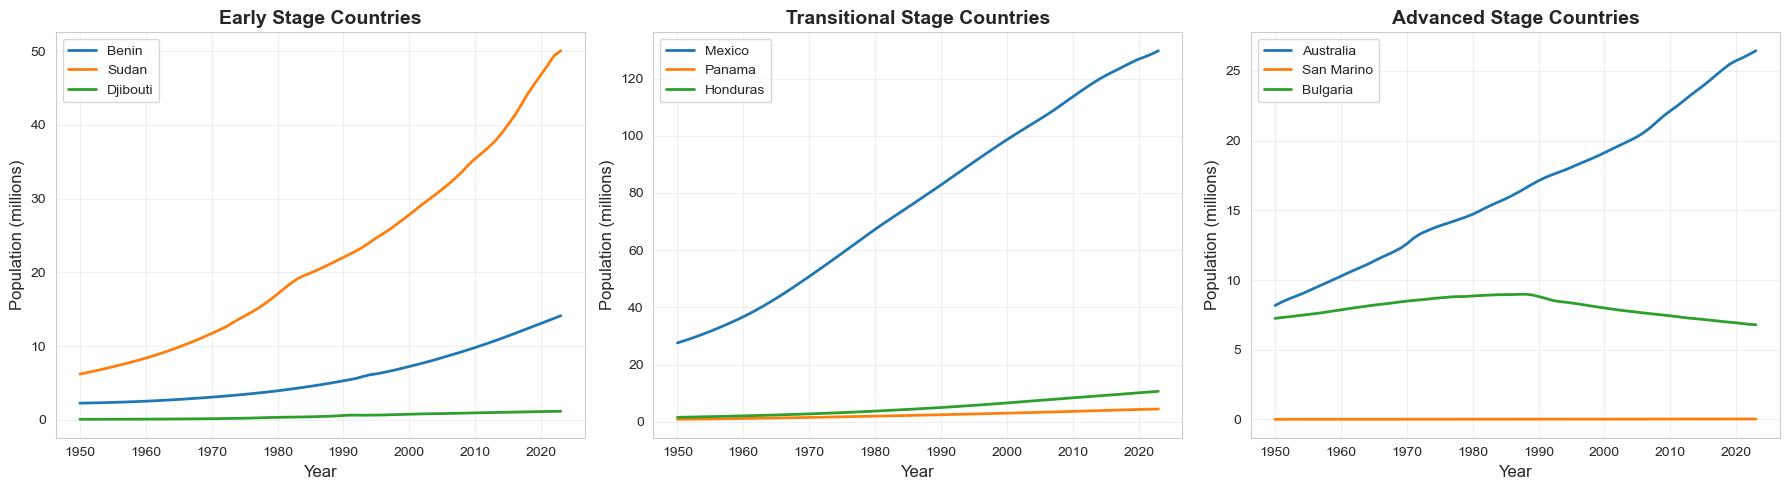

In [17]:
# Visualize population trajectories by development stage
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, stage in enumerate(['Early', 'Transitional', 'Advanced']):
    ax = axes[idx]
    
    # Get countries in this stage
    stage_countries = country_stages[country_stages == stage].index
    
    # Randomly select 3 countries
    np.random.seed(42)
    selected_countries = np.random.choice(stage_countries, size=min(3, len(stage_countries)), replace=False)
    
    # Plot each country's population trajectory
    for country in selected_countries:
        country_data = df[df['country'] == country].sort_values('year')
        ax.plot(country_data['year'], country_data['population'] / 1e6, 
                label=country, linewidth=2)
    
    ax.set_title(f'{stage} Stage Countries', fontsize=14, fontweight='bold')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Population (millions)', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Demographic Indicators Over Time

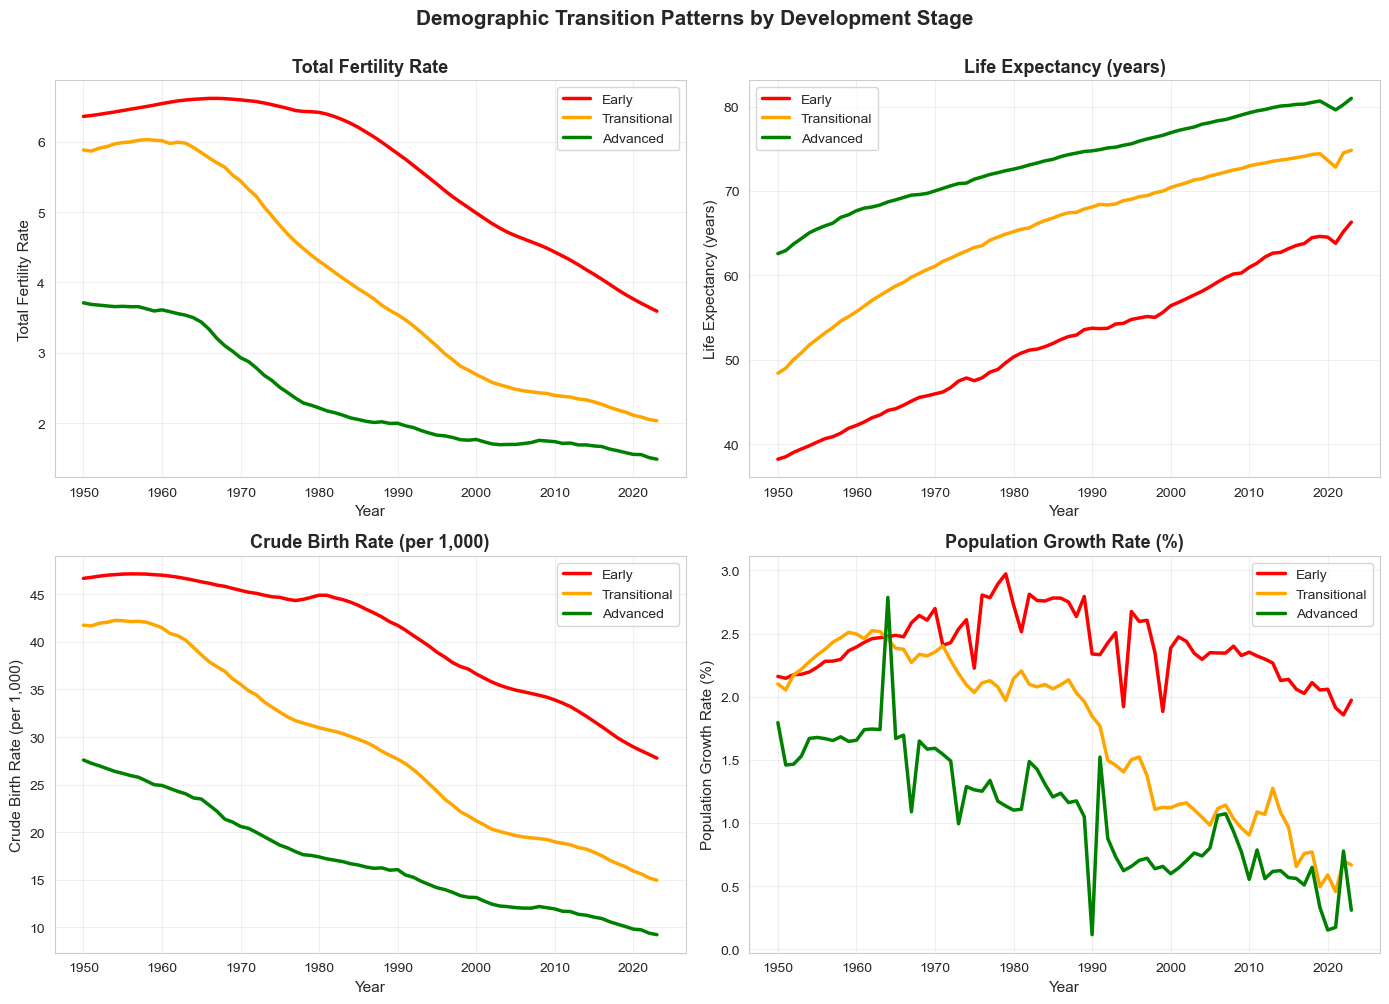

In [18]:
# Visualize how demographic indicators vary by development stage over time
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

indicators = ['tfr', 'life_expectancy', 'crude_birth_rate', 'pop_growth_rate']
titles = ['Total Fertility Rate', 'Life Expectancy (years)', 
          'Crude Birth Rate (per 1,000)', 'Population Growth Rate (%)']
colors = {'Early': 'red', 'Transitional': 'orange', 'Advanced': 'green'}

for idx, (indicator, title) in enumerate(zip(indicators, titles)):
    ax = axes[idx // 2, idx % 2]
    
    for stage in ['Early', 'Transitional', 'Advanced']:
        stage_data = df[df['country_dev_stage'] == stage].groupby('year')[indicator].mean()
        ax.plot(stage_data.index, stage_data.values, 
                label=stage, linewidth=2.5, color=colors[stage])
    
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel('Year', fontsize=11)
    ax.set_ylabel(title, fontsize=11)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('Demographic Transition Patterns by Development Stage', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Correlation Analysis

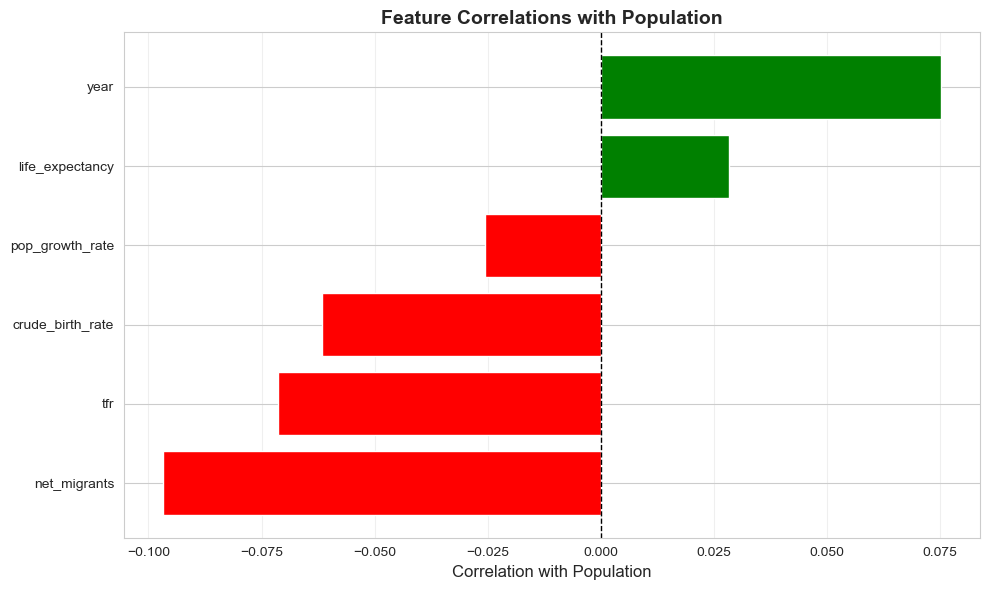


Correlations with Population (sorted):
year                0.075270
life_expectancy     0.028449
pop_growth_rate    -0.025635
crude_birth_rate   -0.061593
tfr                -0.071318
net_migrants       -0.096817
Name: population, dtype: float64


In [19]:
# Calculate correlations with population
numeric_cols = ['year', 'tfr', 'life_expectancy', 'net_migrants', 
                'pop_growth_rate', 'crude_birth_rate', 'population']
correlations = df[numeric_cols].corr()['population'].drop('population').sort_values()

# Visualize correlations
plt.figure(figsize=(10, 6))
plt.barh(correlations.index, correlations.values, 
         color=['red' if x < 0 else 'green' for x in correlations.values])
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Correlation with Population', fontsize=12)
plt.title('Feature Correlations with Population', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nCorrelations with Population (sorted):")
print(correlations.sort_values(ascending=False))

# Feasibility Assessment

In [21]:
# Comprehensive feasibility assessment
print("FEASIBILITY ASSESSMENT FOR TIME SERIES MODELING")

print(f"\n1. Dataset Size:")
print(f"   Total observations: {len(df):,}")
print(f"   Number of countries: {df['country'].nunique()}")
print(f"   Years covered: {df['year'].min():.0f} - {df['year'].max():.0f} ({df['year'].max() - df['year'].min():.0f} years)")

print(f"\n2. Data Quality:")
print(f"   Missing values: {df.isnull().sum().sum()} (0%)")
print(f"   All data pre-cleaned")

obs_per_country = df.groupby('country').size()
print(f"\n3. Observations per Country:")
print(f"   Minimum: {obs_per_country.min()}")
print(f"   Median: {obs_per_country.median():.0f}")
print(f"   Maximum: {obs_per_country.max()}")
print(f"   Countries with 50+ years: {(obs_per_country >= 50).sum()} out of {len(obs_per_country)}")

print(f"\n4. Development Stage Distribution:")
stage_counts = df['country_dev_stage'].value_counts().sort_index()
for stage in ['Early', 'Transitional', 'Advanced']:
    count = stage_counts.get(stage, 0)
    pct = (count / len(df)) * 100
    print(f"   {stage}: {count:,} observations ({pct:.1f}%)")

print(f"\n5. Time Series Suitability:")
print(f"   Sequential data ordered by year")
print(f"   Multiple countries for cross-sectional analysis")
print(f"   Sufficient temporal coverage (74 years)")
print(f"   Rich feature set (demographic indicators)")

print("CONCLUSION: Dataset is SUITABLE for time series regression")

FEASIBILITY ASSESSMENT FOR TIME SERIES MODELING

1. Dataset Size:
   Total observations: 17,538
   Number of countries: 237
   Years covered: 1950 - 2023 (73 years)

2. Data Quality:
   Missing values: 0 (0%)
   All data pre-cleaned

3. Observations per Country:
   Minimum: 74
   Median: 74
   Maximum: 74
   Countries with 50+ years: 237 out of 237

4. Development Stage Distribution:
   Early: 5,402 observations (30.8%)
   Transitional: 6,586 observations (37.6%)
   Advanced: 5,550 observations (31.6%)

5. Time Series Suitability:
   Sequential data ordered by year
   Multiple countries for cross-sectional analysis
   Sufficient temporal coverage (74 years)
   Rich feature set (demographic indicators)
CONCLUSION: Dataset is SUITABLE for time series regression


# Prepare Data for Modeling

In [22]:
# Define features and target
feature_cols = ['year', 'tfr', 'life_expectancy', 'net_migrants', 
                'pop_growth_rate', 'crude_birth_rate']
target_col = 'population'

X = df[feature_cols].copy()
y = df[target_col].copy()

print("Feature Matrix (X) shape:", X.shape)
print("Target Vector (y) shape:", y.shape)
print("\nFeature Statistics:")
print(X.describe())

Feature Matrix (X) shape: (17538, 6)
Target Vector (y) shape: (17538,)

Feature Statistics:
               year           tfr  life_expectancy  net_migrants  \
count  17538.000000  17538.000000     17538.000000  1.753800e+04   
mean    1986.500000      3.973283        63.871295 -3.307105e-03   
std       21.360618      2.024466        12.061574  1.428391e+05   
min     1950.000000      0.662000        10.989000 -5.699445e+06   
25%     1968.000000      2.120000        56.167750 -9.209000e+03   
50%     1986.500000      3.531500        66.532500 -1.710000e+02   
75%     2005.000000      5.933750        72.897250  3.290750e+03   
max     2023.000000      8.864000        86.372000  1.889129e+06   

       pop_growth_rate  crude_birth_rate  
count     17538.000000      17538.000000  
mean          1.730244         28.683073  
std           2.042151         13.506532  
min         -71.064000          3.519000  
25%           0.681000         16.380250  
50%           1.690500         27.588

# Train-test split

In [23]:
# Critical: Use time-based split (no shuffling!)
train_mask = df['year'] < 2000
test_mask = df['year'] >= 2000

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

# Store metadata for later analysis
test_countries = df[test_mask]['country'].values
test_years = df[test_mask]['year'].values
test_dev_stage = df[test_mask]['country_dev_stage'].values

print("TEMPORAL TRAIN-TEST SPLIT")
print(f"\nTraining Set (year < 2000):")
print(f"  Size: {len(X_train):,} observations ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Year range: {df[train_mask]['year'].min():.0f} - {df[train_mask]['year'].max():.0f}")

print(f"\nTest Set (year >= 2000):")
print(f"  Size: {len(X_test):,} observations ({len(X_test)/len(X)*100:.1f}%)")
print(f"  Year range: {df[test_mask]['year'].min():.0f} - {df[test_mask]['year'].max():.0f}")
print(f"  Unique countries in test: {len(np.unique(test_countries))}")

TEMPORAL TRAIN-TEST SPLIT

Training Set (year < 2000):
  Size: 11,850 observations (67.6%)
  Year range: 1950 - 1999

Test Set (year >= 2000):
  Size: 5,688 observations (32.4%)
  Year range: 2000 - 2023
  Unique countries in test: 237


# Feature Scaling

In [24]:
# Standardize features (fit on training only!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify scaling
print("Scaled Training Data Verification:")
print(f"  Mean (should be ~0): {X_train_scaled.mean(axis=0)}")
print(f"  Std (should be ~1): {X_train_scaled.std(axis=0)}")

Scaled Training Data Verification:
  Mean (should be ~0): [-1.49903531e-18 -1.84681150e-16  8.37061316e-16 -2.39845649e-18
  5.75629558e-17  1.87079606e-16]
  Std (should be ~1): [1. 1. 1. 1. 1. 1.]
